# Convolutional Neural Network (CNN) for mnist

### やること
mnistデータベースのデータを使って,**手書き数字を識別するニューラルネット**を作成
- mnistデータベース = 手書き数字画像のデータがたくさん入ってるデータベース

# Setup

### 学習データのダウンロード

In [3]:
from keras.datasets import mnist
from keras.utils import np_utils
(trainX, trainy), (testX, testy) = mnist.load_data()

# Reshape input from 60000x784 to 60000x1x28x28. (sample_size x channel_num x image_width, image_height)
trainX, testX = [x.reshape(x.shape[0], 1, x.shape[1], x.shape[2]) for x in [trainX, testX]]
trainY, testY = [np_utils.to_categorical(y, 10) for y in [trainy, testy]]

# Scale input
trainX = trainX.astype('float32')
testX = testX.astype('float32')
trainX /= 255
testX /= 255

Using Theano backend.


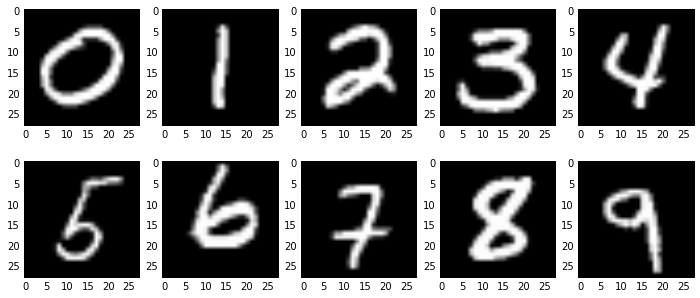

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import random

def fetch_sample_input_for_all_class(class_num, X, y):
    def fetch_sample_input_of_class(i):
        all_target_class_data = [x for x, cls in zip(X, y) if cls == i]
        return random.sample(all_target_class_data, 1)[0]
    return [fetch_sample_input_of_class(i) for i in range(class_num)]

plt.figure(figsize=(12, 5))
for cls, data in enumerate(fetch_sample_input_for_all_class(10, testX, testy), start=1):
    plt.subplot(2, 5, cls)
    plt.imshow(data.reshape(28, 28), cmap="gray")
plt.show()

# Start Learning

#### Model Architecture
1. Input is N x 1 x 28 x 28
  - N = sample_num, 1 = channel num, 28 = img_size (image size is 28x28)
2. Input is processed by first Convolutional layer (filter_num=32, filter_size=3x3 )
  - output is N x 32 x 26 x 26 (image is shrinked because convolution process with "valid" border mode)
    - 26 = img_size - filter_size + 1 = 28 - 3 + 1
3. Output  is processed by second Convolutional layer (filter_num=32, filter_size=3x3 )
  - output is N x 32 x 24 x 24
    - 24 = img_size - filter_size + 1 = 26 - 3 + 1
4. Flatten output before passing it to all-connected layers
  - output is N x 18432 (18432=32x24x24)
5. Output is processed by usual all-connected layer which has 128 unit
  - output is N x 128
6. Output is processed by usual all-connected layer which has 10 unit (10 is number of class to classify)
  - output is N x 10
7. Softmax the last output
  - output is N x 10

### モデルの定義

In [2]:
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers.core import Activation, Flatten, Dense

model = Sequential()
model.add(Convolution2D(32, 3, 3, border_mode="valid", input_shape=(1,28,28)))
model.add(Activation("relu"))
model.add(Convolution2D(32, 3, 3))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation("relu"))
model.add(Dense(10))
model.add(Activation("softmax"))

model.compile(loss="categorical_crossentropy", optimizer="adadelta", metrics=["accuracy"])

### 学習スタート

In [4]:
import os

model_file_path = "model_weights.hdf5"
if os.path.exists(model_file_path):
    model.load_weights(model_file_path)
else:
    model.fit(trainX, trainY, batch_size=128, nb_epoch=1, verbose=1, validation_split=0.1)

print "accuracy = %f" % model.evaluate(testX, testY)[1]

10000/10000 [==============================] - 13s    
accuracy = 0.973600


# 出力層のユニットが入力にどのように反応しているか可視化する

- Refference of "how to visualize output of hidden layer"
  - http://keras.io/getting-started/faq/#how-can-i-visualize-the-output-of-an-intermediate-layer

In [86]:
from keras import backend as K

cnv1, act1, cnv2, act2, pool, flat, hid1, act3, out, sftmx = model.layers
sftmx_output = K.function([cnv1.input], [sftmx.output])

record = [[None for _ in range(28)] for _ in range(28)]
for i in range(28):
    for j in range(28):
        X = np.zeros((1,28,28))
        X[0][i][j] = 1
        record[i][j] = sftmx_output([[X]])[0]

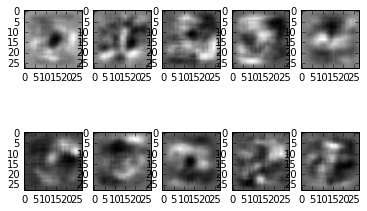

In [87]:
%matplotlib inline
import matplotlib.pyplot as plt

ndrecord = np.array(record).reshape(784, 10)

for i, rec in enumerate(ndrecord.T):
    plt.subplot(2,5, i+1)
    plt.imshow(rec.reshape(28,28), cmap="gray")
plt.show()

- 出力層の10個のユニットが入力のどの部分に強く反応するかを画像にしたもの
  - 例) 左上は出力層の1つ目のユニット(入力が0っぽいかを判断する役割)に対応
- 各ユニットは「画像の白くなっている部分に文字がある or 黒くなっている部分に文字がない」と自分の担当する数字っぽいと判断する
  - 例) 出力層の1つ目のユニットは，ゼロの真ん中の空洞の部分を認識して,判断してるっぽい